# Demo notebook for performing EDA with Python, based on SQLite "database"

In [1]:
import sqlite3
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pwd

'/Users/ddi/JupyterProjects'

In [3]:
ls

CNN_MNIST_GPU.ipynb               kmeans.ipynb
CNN_MNIST_GPU_cl.ipynb            kmeans_cl.ipynb
INF554AssessmentSolutions.ipynb   knn_cl.ipynb
PAPERS.md                         lin_reg.ipynb
README.md                         lin_reg_cl.ipynb
Task_Data_Scientist.pdf           log_reg_cl.ipynb
Task_Data_Scientist_Dataset.xlsx  lra.ipynb
XGBoost.ipynb                     lra_cl.ipynb
XGBoost_cl.ipynb                  mnist_cnn.h5
XGBoost_cl_v2.ipynb               nb_cl.ipynb
aurora/                           stat.ipynb
data/                             stat_cl.ipynb
dbscan.ipynb                      svm.ipynb
eda_sqlite_f1.ipynb               svm_cl.ipynb
interview_obb_DeyanIvanov.ipynb   test.ipynb


In [4]:
cd data

/Users/ddi/JupyterProjects/data


In [5]:
ls

Formula1.sqlite                     emails.csv
Formula1_4tables.sqlite             healthcare-dataset-stroke-data.csv
ai2.jpg                             history-of-rock-spotify.csv
data_churn.csv                      py.png


# Creating database connections and queries

In [6]:
db = {}
db['connect_f14t'] = sqlite3.connect('/Users/ddi/JupyterProjects/data/Formula1_4tables.sqlite')
db['connect_f1'] = sqlite3.connect('/Users/ddi/JupyterProjects/data/Formula1.sqlite')

# SQLite files contain sqlite_master table with information about the tables in the database 
db['query_master'] = '''
                      SELECT name
                      FROM sqlite_master
                      WHERE type='table';
                      '''

In [7]:
# Creating a cursor to uses the connection and list all tables in the db
cursor = db['connect_f14t'].cursor()
cursor.execute(db['query_master'])
cursor.fetchall()

[('circuits',), ('races',), ('drivers',), ('results',)]

In [8]:
cursor = db['connect_f1'].cursor()
cursor.execute(db['query_master'])
cursor.fetchall()

[('circuits',),
 ('races',),
 ('driver_standings',),
 ('drivers',),
 ('constructors',),
 ('results',),
 ('constructor_standings',),
 ('constructor_results',),
 ('laptimes',),
 ('pitstops',),
 ('qualifying',),
 ('seasons',),
 ('status',)]

In [9]:
cursor = db['connect_f1'].cursor()
cursor.execute(db['query_master'])
tables = cursor.fetchall()
type(tables[0])

tuple

In [10]:
tables = [re.sub(r'[(),\']', '', item[0]) for item in tables]
tables[0]

'circuits'

In [11]:
query = {}
data = {}

for item in tables:
    query[f'{item}'] =  f'''
                        SELECT *
                        FROM {item}
                        LIMIT 10;
                        '''
    print('\nQuery:\n', query[f'{item}'])
    
    data[f'{item}'] = pd.read_sql_query(query[f'{item}'], db['connect_f1'])
    print('\n\nData:\n\n', data[f'{item}'])


Query:
 
                        SELECT *
                        FROM circuits
                        LIMIT 10;
                        


Data:

    circuitId      circuitRef                            name      location  \
0          1     albert_park  Albert Park Grand Prix Circuit     Melbourne   
1          2          sepang    Sepang International Circuit  Kuala Lumpur   
2          3         bahrain   Bahrain International Circuit        Sakhir   
3          4       catalunya  Circuit de Barcelona-Catalunya     MontmelÃ_   
4          5        istanbul                   Istanbul Park      Istanbul   
5          6          monaco               Circuit de Monaco   Monte-Carlo   
6          7      villeneuve       Circuit Gilles Villeneuve      Montreal   
7          8     magny_cours   Circuit de Nevers Magny-Cours   Magny Cours   
8          9     silverstone             Silverstone Circuit   Silverstone   
9         10  hockenheimring                  Hockenheimring    Hocken

In [12]:
query = '''
        SELECT drivers.forename AS 'first_name', 
               drivers.surname AS 'last_name',
               constructors.name AS 'team_name',
               races.name AS 'race_name',
               races.date AS 'race_date',
               results.laps AS 'race_laps',
               MAX(pitstops.stop) AS 'race_pitstops',
               qualifying.number AS 'start_position',
               results.positionOrder AS 'finish_position',
               results.points AS 'points'
        FROM results
        JOIN drivers ON results.driverId = drivers.driverId
        JOIN constructors ON results.constructorId = constructors.constructorId
        JOIN races ON results.raceId = races.raceId
        JOIN pitstops ON results.raceId = pitstops.raceId AND results.driverId = pitstops.driverId
        JOIN qualifying ON results.raceId = qualifying.raceId AND results.driverId = qualifying.driverId AND results.constructorId = qualifying.constructorId
        WHERE results.positionOrder IN (1, 2, 3)
        GROUP BY drivers.driverId, races.date, results.positionOrder
        ORDER BY races.date, results.positionOrder;
        '''


# Data load and EDA

In [13]:
data = pd.read_sql_query(query, db['connect_f1'])
data['pilot_name'] = data['first_name'] + ' ' + data['last_name']
data = data.drop(['first_name', 'last_name'], axis = 1)
data = data[['pilot_name', 'team_name', 'race_name', 'race_date', 'race_laps', 'race_pitstops', 'start_position', 'finish_position', 'points']]
data

,pilot_name,team_name,race_name,race_date,race_laps,race_pitstops,start_position,finish_position,points
0,Sebastian Vettel,Red Bull,Australian Grand Prix,2011-03-27,58,2,1,1,25
1,Lewis Hamilton,McLaren,Australian Grand Prix,2011-03-27,58,2,3,2,18
2,Vitaly Petrov,Renault,Australian Grand Prix,2011-03-27,58,2,10,3,15
3,Sebastian Vettel,Red Bull,Malaysian Grand Prix,2011-04-10,56,3,1,1,25
4,Jenson Button,McLaren,Malaysian Grand Prix,2011-04-10,56,3,4,2,18
...,...,...,...,...,...,...,...,...,...
406,Valtteri Bottas,Mercedes,Brazilian Grand Prix,2017-11-12,71,4,77,2,18
407,Kimi R�_ikk̦nen,Ferrari,Brazilian Grand Prix,2017-11-12,71,4,7,3,15
408,Valtteri Bottas,Mercedes,Abu Dhabi Grand Prix,2017-11-26,55,1,77,1,25
409,Lewis Hamilton,Mercedes,Abu Dhabi Grand Prix,2017-11-26,55,1,44,2,18


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   pilot_name       411 non-null    object
 1   team_name        411 non-null    object
 2   race_name        411 non-null    object
 3   race_date        411 non-null    object
 4   race_laps        411 non-null    int64 
 5   race_pitstops    411 non-null    int64 
 6   start_position   411 non-null    int64 
 7   finish_position  411 non-null    int64 
 8   points           411 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 29.0+ KB


In [15]:
data.describe()

,race_laps,race_pitstops,start_position,finish_position,points
count,411.000000,411.000000,411.000000,411.000000,411.000000
mean,59.875912,2.141119,15.812652,2.000000,19.474453
std,8.551804,0.928958,20.697860,0.817492,4.549586
min,43.000000,1.000000,1.000000,1.000000,15.000000
25%,54.000000,1.000000,3.000000,1.000000,15.000000
50%,57.000000,2.000000,6.000000,2.000000,18.000000
75%,69.000000,3.000000,19.000000,3.000000,25.000000
max,78.000000,6.000000,77.000000,3.000000,50.000000




Unique values of pilot_name:

 ['Sebastian Vettel' 'Lewis Hamilton' 'Vitaly Petrov' 'Jenson Button'
 'Nick Heidfeld' 'Mark Webber' 'Fernando Alonso' 'Sergio P̩rez'
 'Nico Rosberg' 'Kimi R�_ikk̦nen' 'Romain Grosjean' 'Pastor Maldonado'
 'Michael Schumacher' 'Felipe Massa' 'Kamui Kobayashi' 'Kevin Magnussen'
 'Daniel Ricciardo' 'Valtteri Bottas' 'Daniil Kvyat' 'Max Verstappen'
 'Lance Stroll']


Number of unique values of pilot_name:

 21


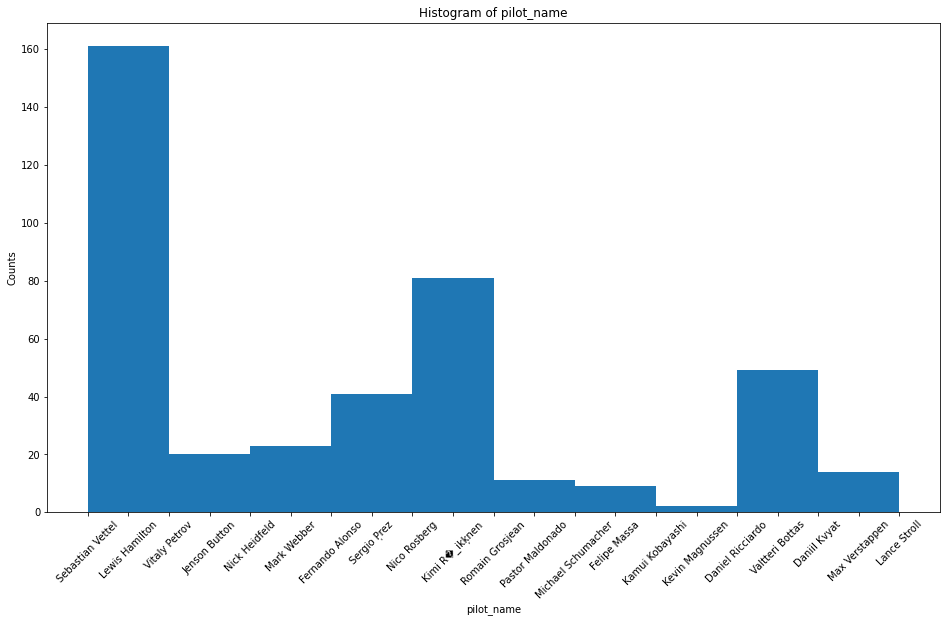



Unique values of team_name:

 ['Red Bull' 'McLaren' 'Renault' 'Ferrari' 'Sauber' 'Mercedes' 'Lotus F1'
 'Williams' 'Force India']


Number of unique values of team_name:

 9


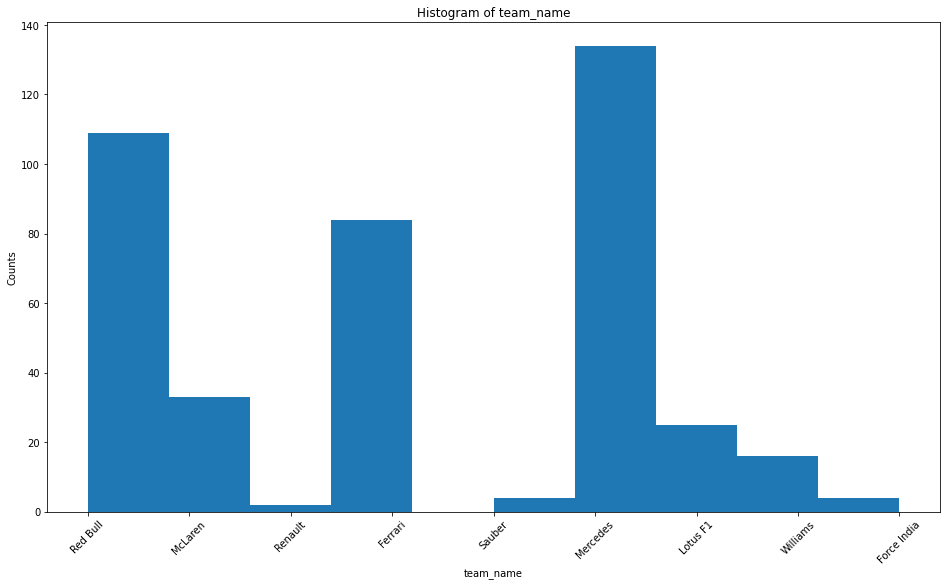



Unique values of race_name:

 ['Australian Grand Prix' 'Malaysian Grand Prix' 'Chinese Grand Prix'
 'Turkish Grand Prix' 'Spanish Grand Prix' 'Monaco Grand Prix'
 'Canadian Grand Prix' 'European Grand Prix' 'British Grand Prix'
 'German Grand Prix' 'Hungarian Grand Prix' 'Belgian Grand Prix'
 'Italian Grand Prix' 'Singapore Grand Prix' 'Japanese Grand Prix'
 'Korean Grand Prix' 'Indian Grand Prix' 'Abu Dhabi Grand Prix'
 'Brazilian Grand Prix' 'Bahrain Grand Prix' 'United States Grand Prix'
 'Austrian Grand Prix' 'Russian Grand Prix' 'Mexican Grand Prix'
 'Azerbaijan Grand Prix']


Number of unique values of race_name:

 25


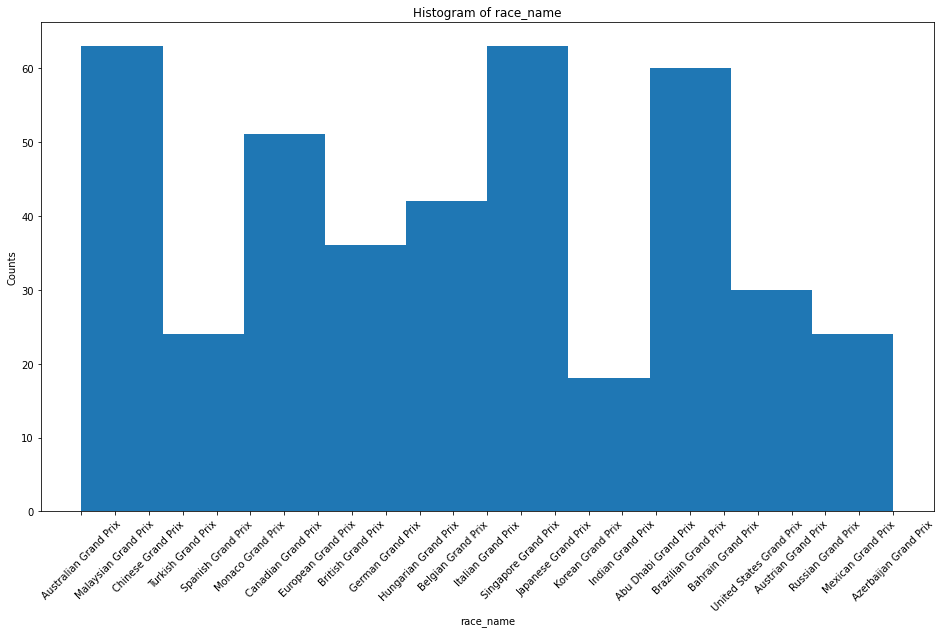



Unique values of race_date:

 ['2011-03-27' '2011-04-10' '2011-04-17' '2011-05-08' '2011-05-22'
 '2011-05-29' '2011-06-12' '2011-06-26' '2011-07-10' '2011-07-24'
 '2011-07-31' '2011-08-28' '2011-09-11' '2011-09-25' '2011-10-09'
 '2011-10-16' '2011-10-30' '2011-11-13' '2011-11-27' '2012-03-18'
 '2012-03-25' '2012-04-15' '2012-04-22' '2012-05-13' '2012-05-27'
 '2012-06-10' '2012-06-24' '2012-07-08' '2012-07-22' '2012-07-29'
 '2012-09-02' '2012-09-09' '2012-09-23' '2012-10-07' '2012-10-14'
 '2012-10-28' '2012-11-04' '2012-11-18' '2012-11-25' '2013-03-17'
 '2013-03-24' '2013-04-14' '2013-04-21' '2013-05-12' '2013-05-26'
 '2013-06-09' '2013-06-30' '2013-07-07' '2013-07-28' '2013-08-25'
 '2013-09-08' '2013-09-22' '2013-10-06' '2013-10-13' '2013-10-27'
 '2013-11-03' '2013-11-17' '2013-11-24' '2014-03-16' '2014-03-30'
 '2014-04-06' '2014-04-20' '2014-05-11' '2014-05-25' '2014-06-08'
 '2014-06-22' '2014-07-06' '2014-07-20' '2014-07-27' '2014-08-24'
 '2014-09-07' '2014-09-21' '2014-10-05' '201

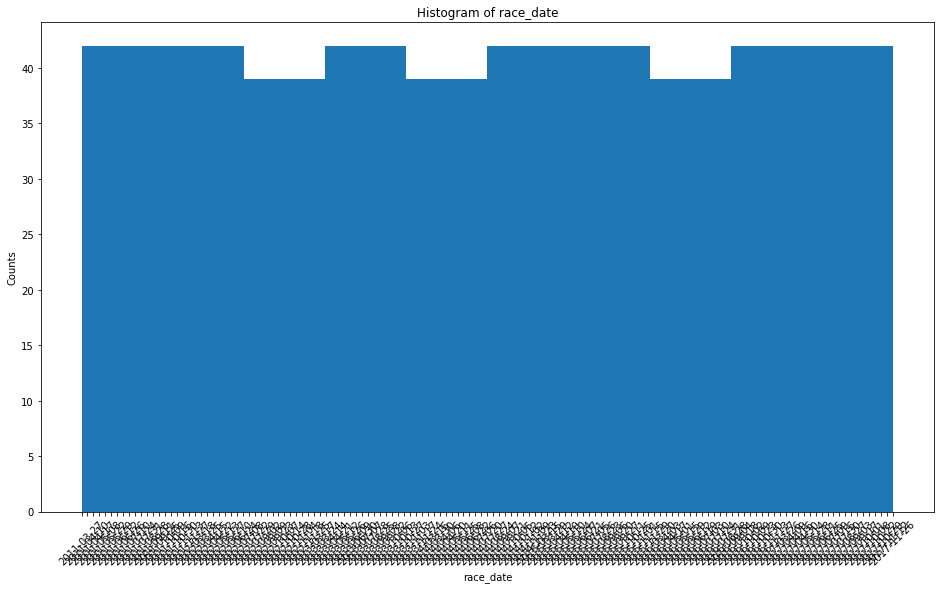



Unique values of race_laps:

 [58 56 66 78 70 57 52 60 44 53 61 55 71 67 69 59 54 43 51]


Number of unique values of race_laps:

 19


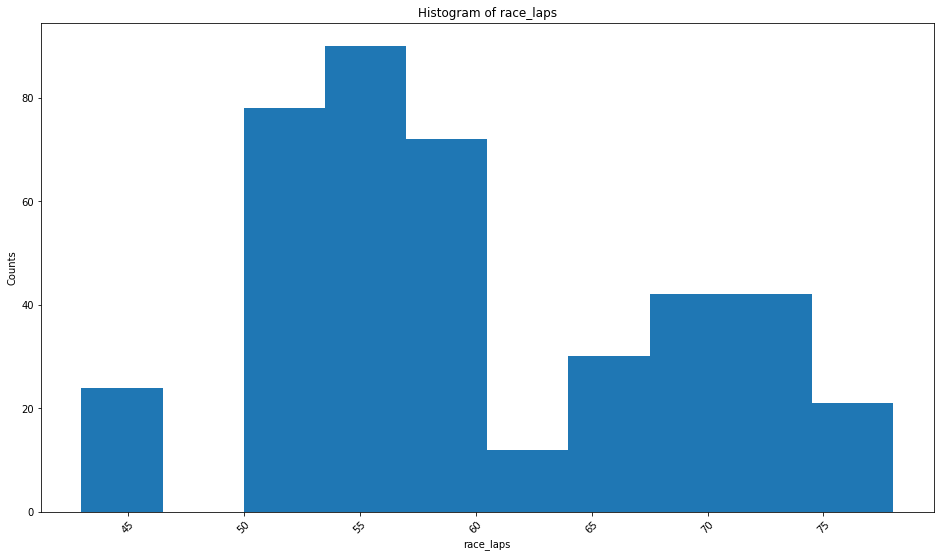



Unique values of race_pitstops:

 [2 3 4 1 6 5]


Number of unique values of race_pitstops:

 6


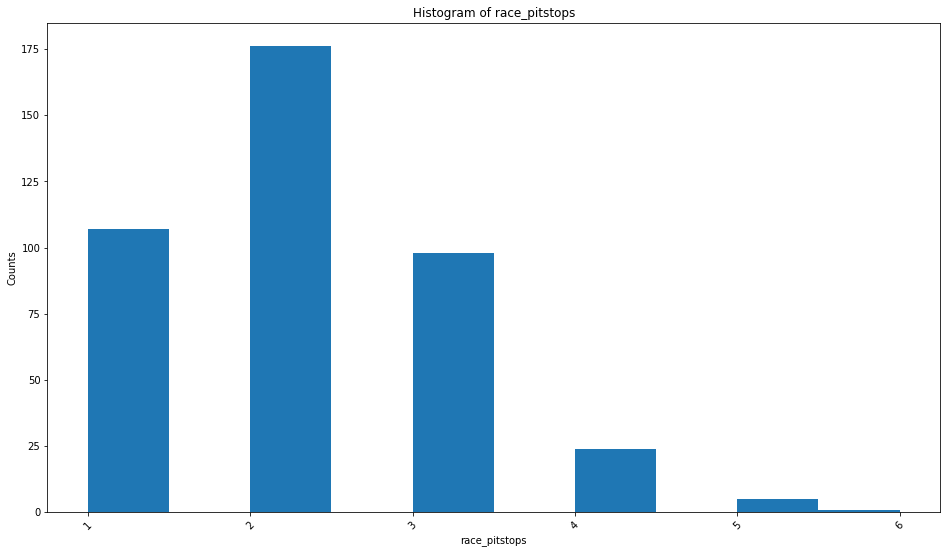



Unique values of start_position:

 [ 1  3 10  4  9  2  5 15  8 18  7  6 14 20 22 44 11 77 19 26 33]


Number of unique values of start_position:

 21


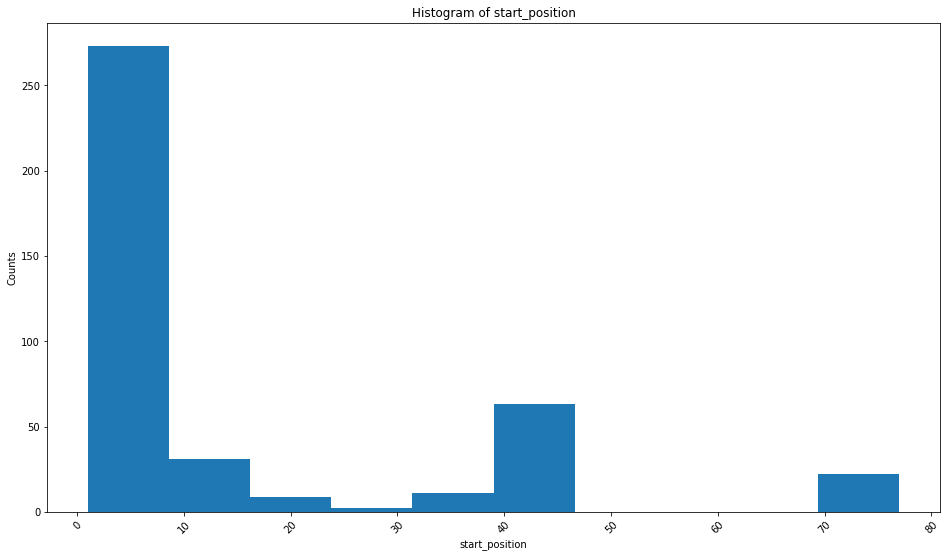



Unique values of finish_position:

 [1 2 3]


Number of unique values of finish_position:

 3


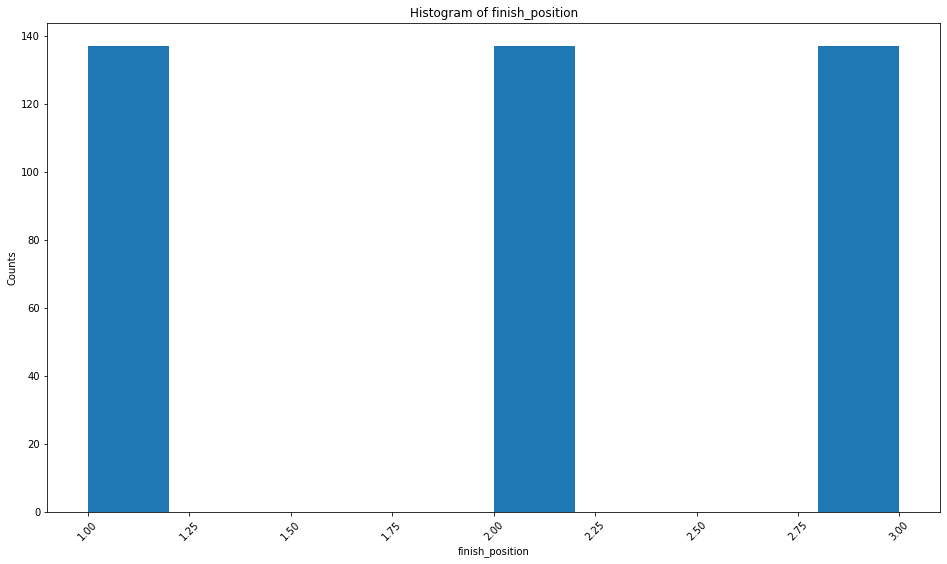



Unique values of points:

 [25 18 15 50 36 30]


Number of unique values of points:

 6


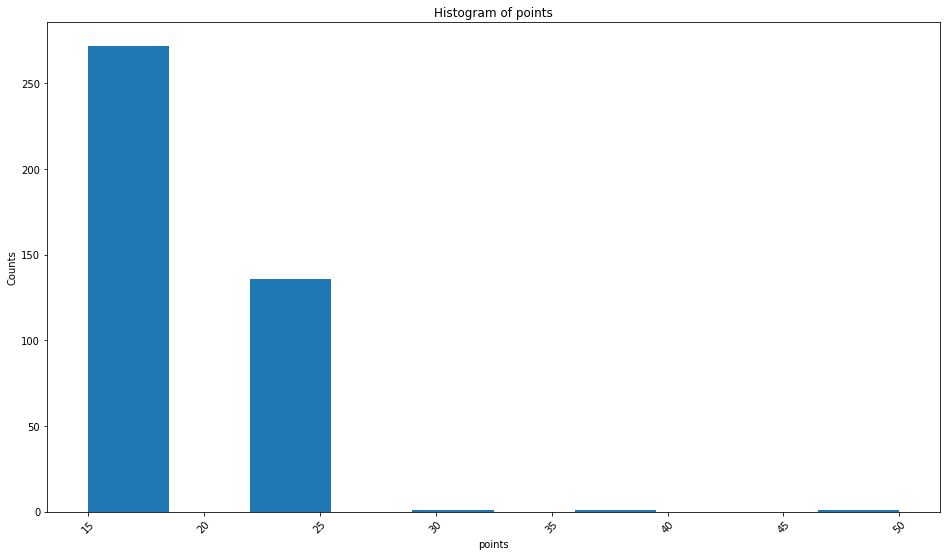

In [16]:
for col in data.columns:
    print(f'\n\nUnique values of {col}:\n\n', data[col].unique())
    print(f'\n\nNumber of unique values of {col}:\n\n', data[col].nunique())
    
    plt.figure(figsize=(16,9))
    plt.hist(data[col])
    plt.title(f'Histogram of {col}')
    plt.xlabel(f'{col}')
    plt.xticks(rotation=45)
    plt.ylabel('Counts')
    plt.show()

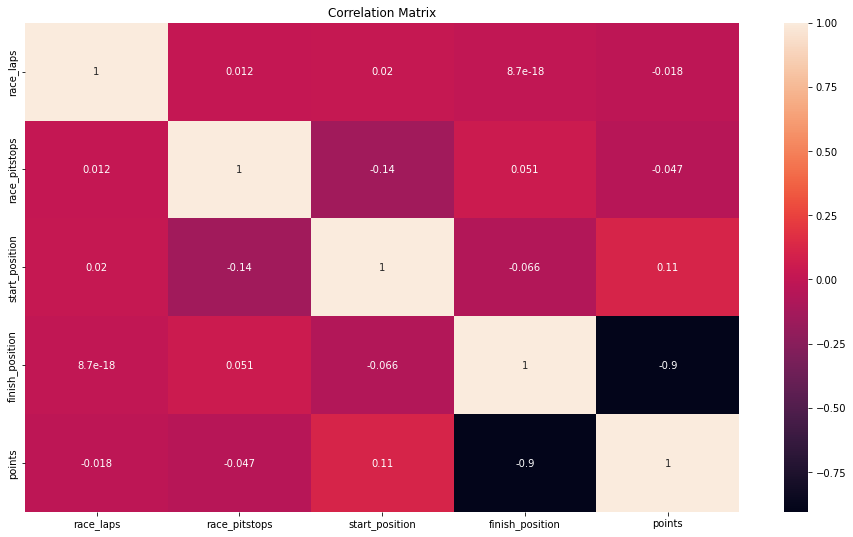

In [17]:
plt.figure(figsize=(16,9))
sns.heatmap(data.corr(), annot = True)
plt.title('Correlation Matrix')
plt.show()

# Which pilots and teams have won the most points

In [18]:
data[['pilot_name','points']].groupby('pilot_name').sum().sort_values(by='points', ascending=False)

,points
pilot_name,
Lewis Hamilton,1777
Sebastian Vettel,1636
Nico Rosberg,1082
Fernando Alonso,618
Kimi R�_ikk̦nen,497
Daniel Ricciardo,473
Valtteri Bottas,399
Mark Webber,384
Jenson Button,366


In [19]:
data[['team_name','points']].groupby('team_name').sum().sort_values(by='points', ascending=False)

,points
team_name,
Mercedes,2843
Red Bull,2125
Ferrari,1502
McLaren,658
Lotus F1,428
Williams,292
Sauber,66
Force India,60
Renault,30


# Starting positions by pilots and teams

In [20]:
data[['pilot_name','start_position']].groupby('pilot_name').value_counts()

pilot_name          start_position
Daniel Ricciardo    3                 27
Daniil Kvyat        26                 2
Felipe Massa        19                 5
                    6                  2
                    4                  1
Fernando Alonso     5                 23
                    3                  9
                    14                 2
Jenson Button       4                 12
                    3                  6
                    22                 1
Kamui Kobayashi     14                 1
Kevin Magnussen     20                 1
Kimi R�_ikk̦nen     7                 22
                    9                  7
Lance Stroll        18                 1
Lewis Hamilton      44                63
                    4                  7
                    3                  6
                    10                 5
Mark Webber         2                 22
Max Verstappen      33                11
Michael Schumacher  7                  1
Nick Heidfeld       9 

In [21]:
data[['team_name','start_position']].groupby('team_name').value_counts()

team_name    start_position
Ferrari      5                 56
             7                 14
             3                  9
             6                  2
             14                 2
             4                  1
Force India  11                 4
Lotus F1     7                  8
             9                  7
             8                  7
             10                 3
McLaren      4                 19
             3                 12
             22                 1
             20                 1
Mercedes     44                63
             6                 46
             77                13
             10                 5
             9                  4
             8                  2
             7                  1
Red Bull     1                 47
             3                 27
             2                 22
             33                11
             26                 2
Renault      9                  1
             10     

# Finishing positions by pilots and teams

In [22]:
data[['pilot_name','finish_position']].groupby('pilot_name').value_counts()

pilot_name          finish_position
Daniel Ricciardo    3                  16
                    2                   6
                    1                   5
Daniil Kvyat        3                   1
                    2                   1
Felipe Massa        3                   6
                    2                   2
Fernando Alonso     2                  16
                    3                  12
                    1                   6
Jenson Button       2                   7
                    3                   6
                    1                   6
Kamui Kobayashi     3                   1
Kevin Magnussen     2                   1
Kimi R�_ikk̦nen     2                  14
                    3                  13
                    1                   2
Lance Stroll        3                   1
Lewis Hamilton      1                  48
                    2                  19
                    3                  14
Mark Webber         3                  1

In [23]:
data[['team_name','finish_position']].groupby('team_name').value_counts()

team_name    finish_position
Ferrari      3                  36
             2                  34
             1                  14
Force India  3                   4
Lotus F1     3                  12
             2                  11
             1                   2
McLaren      1                  13
             2                  11
             3                   9
Mercedes     1                  67
             2                  46
             3                  21
Red Bull     1                  40
             3                  39
             2                  30
Renault      3                   2
Sauber       2                   2
             3                   2
Williams     3                  12
             2                   3
             1                   1
dtype: int64

# In which position the pilots and the teams started and won the race

In [24]:
data[['pilot_name','start_position','finish_position']][data['finish_position'] == 1].groupby('pilot_name').value_counts()

pilot_name        start_position  finish_position
Daniel Ricciardo  3               1                   5
Fernando Alonso   5               1                   4
                  3               1                   2
Jenson Button     4               1                   3
                  3               1                   3
Kimi R�_ikk̦nen   7               1                   1
                  9               1                   1
Lewis Hamilton    44              1                  40
                  4               1                   4
                  3               1                   3
                  10              1                   1
Mark Webber       2               1                   3
Max Verstappen    33              1                   3
Nico Rosberg      6               1                  20
                  9               1                   2
                  8               1                   1
Pastor Maldonado  18              1                   

In [25]:
data[['team_name','start_position','finish_position']][data['finish_position'] == 1].groupby('team_name').value_counts()

team_name  start_position  finish_position
Ferrari    5               1                  12
           3               1                   2
Lotus F1   9               1                   1
           7               1                   1
McLaren    4               1                   7
           3               1                   6
Mercedes   44              1                  40
           6               1                  20
           77              1                   3
           9               1                   2
           10              1                   1
           8               1                   1
Red Bull   1               1                  29
           3               1                   5
           33              1                   3
           2               1                   3
Williams   18              1                   1
dtype: int64

# How many pitstops the pilots and the teams have made

In [26]:
data[['pilot_name','race_pitstops']].groupby('pilot_name').value_counts()

pilot_name          race_pitstops
Daniel Ricciardo    2                14
                    1                 7
                    4                 2
                    5                 2
                    3                 2
Daniil Kvyat        3                 1
                    5                 1
Felipe Massa        1                 3
                    3                 2
                    2                 2
                    4                 1
Fernando Alonso     2                15
                    3                10
                    1                 6
                    4                 3
Jenson Button       3                 9
                    2                 8
                    1                 1
                    6                 1
Kamui Kobayashi     2                 1
Kevin Magnussen     2                 1
Kimi R�_ikk̦nen     2                15
                    3                 7
                    1                 6
      

In [27]:
data[['team_name','race_pitstops']].groupby('team_name').value_counts()

team_name    race_pitstops
Ferrari      2                34
             1                24
             3                18
             4                 7
             5                 1
Force India  1                 2
             2                 2
Lotus F1     2                13
             3                 8
             1                 4
McLaren      2                15
             3                13
             1                 3
             6                 1
             4                 1
Mercedes     2                60
             1                43
             3                23
             4                 8
Red Bull     2                44
             3                31
             1                22
             4                 8
             5                 4
Renault      2                 1
             3                 1
Sauber       1                 2
             2                 1
             3                 1
Williams     1  

# Number of pitstops by pilot and team when they have won a race

In [28]:
data[['pilot_name','race_pitstops','finish_position']][data['finish_position'] == 1].groupby('pilot_name').value_counts()

pilot_name        race_pitstops  finish_position
Daniel Ricciardo  2              1                   3
                  3              1                   1
                  4              1                   1
Fernando Alonso   3              1                   3
                  2              1                   2
                  4              1                   1
Jenson Button     2              1                   2
                  3              1                   2
                  1              1                   1
                  6              1                   1
Kimi R�_ikk̦nen   1              1                   1
                  2              1                   1
Lewis Hamilton    2              1                  22
                  1              1                  16
                  3              1                   7
                  4              1                   3
Mark Webber       3              1                   1
                

In [29]:
data[['team_name','race_pitstops','finish_position']][data['finish_position'] == 1].groupby('team_name').value_counts()

team_name  race_pitstops  finish_position
Ferrari    2              1                   5
           1              1                   3
           3              1                   3
           4              1                   3
Lotus F1   2              1                   1
           1              1                   1
McLaren    2              1                   5
           3              1                   4
           1              1                   3
           6              1                   1
Mercedes   2              1                  30
           1              1                  24
           3              1                  10
           4              1                   3
Red Bull   2              1                  20
           3              1                   9
           1              1                   7
           4              1                   4
Williams   3              1                   1
dtype: int64

# Which pilots and teams have won which race and how many times they did it

In [30]:
data[['pilot_name','race_name','finish_position']][data['finish_position'] == 1].groupby('pilot_name').value_counts()

pilot_name        race_name              finish_position
Daniel Ricciardo  Azerbaijan Grand Prix  1                  1
                  Canadian Grand Prix    1                  1
                  Hungarian Grand Prix   1                  1
                  Malaysian Grand Prix   1                  1
                  Belgian Grand Prix     1                  1
                                                           ..
Sebastian Vettel  Abu Dhabi Grand Prix   1                  1
                  Canadian Grand Prix    1                  1
Valtteri Bottas   Austrian Grand Prix    1                  1
                  Abu Dhabi Grand Prix   1                  1
                  Russian Grand Prix     1                  1
Length: 85, dtype: int64

In [31]:
data[['team_name','race_name','finish_position']][data['finish_position'] == 1].groupby('team_name').value_counts()

team_name  race_name              finish_position
Ferrari    Malaysian Grand Prix   1                  2
           Hungarian Grand Prix   1                  2
           Australian Grand Prix  1                  1
           Bahrain Grand Prix     1                  1
           Brazilian Grand Prix   1                  1
                                                    ..
Red Bull   German Grand Prix      1                  1
           European Grand Prix    1                  1
           Abu Dhabi Grand Prix   1                  1
           British Grand Prix     1                  1
Williams   Spanish Grand Prix     1                  1
Length: 69, dtype: int64

# Which pilots won at least a podium and were part of which team

In [32]:
data[['pilot_name','team_name']].groupby('pilot_name').value_counts()

pilot_name          team_name  
Daniel Ricciardo    Red Bull       27
Daniil Kvyat        Red Bull        2
Felipe Massa        Williams        5
                    Ferrari         3
Fernando Alonso     Ferrari        34
Jenson Button       McLaren        19
Kamui Kobayashi     Sauber          1
Kevin Magnussen     McLaren         1
Kimi R�_ikk̦nen     Lotus F1       15
                    Ferrari        14
Lance Stroll        Williams        1
Lewis Hamilton      Mercedes       68
                    McLaren        13
Mark Webber         Red Bull       22
Max Verstappen      Red Bull       11
Michael Schumacher  Mercedes        1
Nick Heidfeld       Renault         1
Nico Rosberg        Mercedes       52
Pastor Maldonado    Williams        1
Romain Grosjean     Lotus F1       10
Sebastian Vettel    Red Bull       47
                    Ferrari        33
Sergio P̩rez        Force India     4
                    Sauber          3
Valtteri Bottas     Mercedes       13
                  

# Which pilots won at least one race and were part of which team

In [33]:
data[['pilot_name','team_name']][data['finish_position'] == 1].groupby('pilot_name').value_counts()

pilot_name        team_name
Daniel Ricciardo  Red Bull      5
Fernando Alonso   Ferrari       6
Jenson Button     McLaren       6
Kimi R�_ikk̦nen   Lotus F1      2
Lewis Hamilton    Mercedes     41
                  McLaren       7
Mark Webber       Red Bull      3
Max Verstappen    Red Bull      3
Nico Rosberg      Mercedes     23
Pastor Maldonado  Williams      1
Sebastian Vettel  Red Bull     29
                  Ferrari       8
Valtteri Bottas   Mercedes      3
dtype: int64

# Laps per race and how many times it was hosted at the venue

In [34]:
data[['race_name','race_laps']].groupby('race_name').value_counts()

race_name                 race_laps
Abu Dhabi Grand Prix      55           21
Australian Grand Prix     58           12
                          57            9
Austrian Grand Prix       71           12
Azerbaijan Grand Prix     51            3
Bahrain Grand Prix        57           18
Belgian Grand Prix        44           18
                          43            3
Brazilian Grand Prix      71           21
British Grand Prix        52           18
                          51            3
Canadian Grand Prix       70           21
Chinese Grand Prix        56           18
                          54            3
European Grand Prix       57            6
                          51            3
German Grand Prix         67            9
                          60            6
Hungarian Grand Prix      70           15
                          69            6
Indian Grand Prix         60            9
Italian Grand Prix        53           21
Japanese Grand Prix       53           1

# Misc

# How many points each pilot has won

In [35]:
query = '''
        SELECT drivers.forename AS 'first_name', 
               drivers.surname AS 'last_name', 
               drivers.nationality AS 'nationality',
               SUM(results.points) AS 'points_won'
        FROM drivers
        JOIN results ON drivers.driverId = results.driverId
        GROUP BY drivers.driverId
        ORDER BY SUM(results.points) DESC;
        '''

data_allpoints = pd.read_sql_query(query, db['connect_f1'])
data_allpoints.head()

,first_name,last_name,nationality,points_won
0,Lewis,Hamilton,British,2610.0
1,Sebastian,Vettel,German,2425.0
2,Fernando,Alonso,Spanish,1849.0
3,Nico,Rosberg,German,1594.5
4,Michael,Schumacher,German,1566.0


In [36]:
data_allpoints.tail()

,first_name,last_name,nationality,points_won
837,Yuji,Ide,Japanese,0.0
838,Sakon,Yamamoto,Japanese,0.0
839,Markus,Winkelhock,German,0.0
840,Scott,Speed,American,0.0
841,Anthony,Davidson,British,0.0


In [37]:
data_allpoints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   first_name   842 non-null    object 
 1   last_name    842 non-null    object 
 2   nationality  842 non-null    object 
 3   points_won   842 non-null    float64
dtypes: float64(1), object(3)
memory usage: 26.4+ KB


# How many races each pilot has won

In [38]:
query = '''
        SELECT drivers.forename AS 'first_name', 
               drivers.surname AS 'last_name', 
               COUNT(*) AS 'number_of_wins'
        FROM results
        JOIN drivers ON results.driverId = drivers.driverId
        JOIN races ON results.raceId = races.raceId
        WHERE results.positionOrder = 1
        GROUP BY drivers.driverId
        ORDER BY COUNT(*) DESC;
        '''

data_allwins = pd.read_sql_query(query, db['connect_f1'])
data_allwins.head()

,first_name,last_name,number_of_wins
0,Michael,Schumacher,91
1,Lewis,Hamilton,62
2,Alain,Prost,51
3,Sebastian,Vettel,47
4,Ayrton,Senna,41


In [39]:
data_allwins.tail()

,first_name,last_name,number_of_wins
102,Jean,Alesi,1
103,Olivier,Panis,1
104,Jarno,Trulli,1
105,Robert,Kubica,1
106,Heikki,Kovalainen,1


In [40]:
data_allwins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   first_name      107 non-null    object
 1   last_name       107 non-null    object
 2   number_of_wins  107 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 2.6+ KB
